In [417]:
# import necessary libraries
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from tqdm import tqdm

import sklearn
import keras
import tensorflow as tf
from keras.models import Sequential
from sklearn.preprocessing import OneHotEncoder, LabelBinarizer
from keras.layers import Dense, Conv2D, MaxPool2D, Flatten, concatenate
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from keras import optimizers
from keras.applications.vgg16 import VGG16
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, GlobalAveragePooling2D, Dense, Input,Dropout,BatchNormalization
from keras.models import load_model
from sklearn import metrics
from keras.callbacks import ReduceLROnPlateau,EarlyStopping
from keras.optimizers import SGD
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss
from collections import Counter

## Data Preprocessing

In [111]:
# helper function for loading the dataset of images
def load_normal(norm_loc):
    norm_files = np.array(os.listdir(norm_loc))
    norm_labels = np.array(['normal']*len(norm_files))
    
    norm_images = []
    for image in tqdm(norm_files):
        image = cv2.imread(norm_loc + image)
        image = cv2.resize(image, dsize=(180,180))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        norm_images.append(image)
        
    norm_images = np.array(norm_images)
    
    return norm_images, norm_labels
def load_pneumonia(pneu_loc):
    pneu_files = np.array(os.listdir(pneu_loc))
    pneu_labels = np.array(['pneumonia']*len(pneu_files))
    
    pneu_images = []
    for image in tqdm(pneu_files):
        image = cv2.imread(pneu_loc + image)
        image = cv2.resize(image, dsize=(180,180))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        pneu_images.append(image)
        
    pneu_images = np.array(pneu_images)
    
    return pneu_images, pneu_labels

In [113]:
# normal training 
norm_img, norm_labels = load_normal('/Users/Imaddin/Desktop/Computer science/Year 3/Sem 2/FYP/Pneumonia/chest_xray/train/NORMAL/')

100%|██████████████████████████████████████████████████████████████████████████████| 1341/1341 [00:29<00:00, 44.93it/s]


In [114]:
# pneumonia training
pneu_img, pneu_labels = load_pneumonia('/Users/Imaddin/Desktop/Computer science/Year 3/Sem 2/FYP/Pneumonia/chest_xray/train/PNEUMONIA/')

100%|█████████████████████████████████████████████████████████████████████████████| 3875/3875 [00:32<00:00, 120.10it/s]


In [389]:
x_train = np.append(norm_img,pneu_img, axis=0)
y_train = np.append(norm_labels, pneu_labels)

In [116]:
# normal test
norm_test_img, norm_test_labels = load_normal('/Users/Imaddin/Desktop/Computer science/Year 3/Sem 2/FYP/Pneumonia/chest_xray/test/NORMAL/')

100%|████████████████████████████████████████████████████████████████████████████████| 234/234 [00:04<00:00, 52.95it/s]


In [117]:
# pneumonia test
pneu_test_img, pneu_test_labels = load_pneumonia('/Users/Imaddin/Desktop/Computer science/Year 3/Sem 2/FYP/Pneumonia/chest_xray/test/PNEUMONIA/')

100%|███████████████████████████████████████████████████████████████████████████████| 390/390 [00:03<00:00, 126.01it/s]


In [390]:
x_test = np.append(norm_test_img,pneu_test_img, axis=0)
y_test = np.append(norm_test_labels, pneu_test_labels)

In [119]:
# normal val
norm_val_img, norm_val_labels = load_normal('/Users/Imaddin/Desktop/Computer science/Year 3/Sem 2/FYP/Pneumonia/chest_xray/val/NORMAL/')

100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 62.52it/s]


In [120]:
# pneumonia val
pneu_val_img, pneu_val_labels = load_pneumonia('/Users/Imaddin/Desktop/Computer science/Year 3/Sem 2/FYP/Pneumonia/chest_xray/val/PNEUMONIA/')

100%|███████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 124.97it/s]


In [391]:
x_val = np.append(norm_val_img,pneu_val_img, axis=0)
y_val = np.append(norm_val_labels, pneu_val_labels)

From the counter below, we can see that there is a class imbalance between the 2 classes in the training dataset.

In [388]:
print(Counter(y_train))

Counter({'pneumonia': 3875, 'normal': 1341})


### Undersampling 
To tackle the problem of class imbalance, undersampling is used to equalise the number of both classes. 

In [392]:
# reshaping is needed before undersampling the dataset
x_train = x_train.reshape(len(x_train),x_train.shape[1]*x_train.shape[2])
x_test = x_test.reshape(len(x_test),x_test.shape[1]*x_test.shape[2])
x_val = x_val.reshape(len(x_val),x_val.shape[1]*x_val.shape[2])

In [393]:
#undersample using NearMiss version 1
Counter(y_train)
undersampling = NearMiss(version=1)
x_train,y_train = undersampling.fit_resample(x_train,y_train)

With undersampling, it takes the class with higher number of data and reduces it to the same number of data in the class with lesser data. As seen below, the number of pneumonia class is the same as the normal class.

In [394]:
print(Counter(y_train))

Counter({'normal': 1341, 'pneumonia': 1341})


### Label Binarizer
Label binarizer is needed for preprocessing the labels. Since the labels are in string format, i.e. normal and pneumonia, label binarizer helps to convert them into numeric format so that it can be used in the neural network. 

In [395]:
# Label preprocessing
LB = LabelBinarizer()
y_train_LB = LB.fit_transform(y_train)
y_test_LB = LB.transform(y_test)
y_val_LB = LB.transform(y_val)

In [396]:
# reshaping to fit neural network
x_train = x_train.reshape(-1,180,180,1)
x_test = x_test.reshape(-1,180,180,1)
x_val = x_val.reshape(-1,180,180,1)

### Artifical Data Augmentation
This helps to artificially increase the number of the data in the dataset. This is done to prevent overfitting that can occur due to smaller amounts of data.

In [398]:
# data augmentation
augData = ImageDataGenerator(
    rotation_range = 10,
    zoom_range = 0.1,
    width_shift_range = 0.1,
    height_shift_range = 0.1,
    horizontal_flip = True
)

In [399]:
augData.fit(x_train)
train = augData.flow(x_train,y_train_LB, batch_size=32)

## Baseline Model
The baseline model is a naive bayes model

In [413]:
# data preprocessing
# reshaping to fit Naive Bayes Model
x_train = x_train.reshape(len(x_train),x_train.shape[1]*x_train.shape[2])
x_test = x_test.reshape(len(x_test),x_test.shape[1]*x_test.shape[2])
x_val = x_val.reshape(len(x_val),x_val.shape[1]*x_val.shape[2])

In [415]:
# Baseline model
from sklearn.naive_bayes import GaussianNB
nb = GaussianNB()
nb.fit(x_train,y_train_LB)

C:\Users\Imaddin\anaconda3\lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


GaussianNB()

In [420]:
y_pred_NB = nb.predict(x_test)
y_pred_NB = LB.inverse_transform(y_pred_NB)
accuracy_score(y_pred_NB,y_test_LB)
print(classification_report(y_pred_NB, y_test))

              precision    recall  f1-score   support

      normal       0.74      0.70      0.72       244
   pneumonia       0.82      0.84      0.83       380

    accuracy                           0.79       624
   macro avg       0.78      0.77      0.77       624
weighted avg       0.78      0.79      0.78       624



C:\Users\Imaddin\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:226: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


<Figure size 576x432 with 0 Axes>

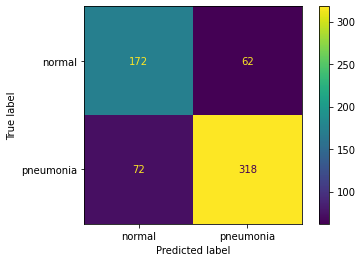

In [421]:
conf_matNB=(confusion_matrix(y_test, y_pred_NB))
plt.figure(figsize=(8,6))
display = metrics.ConfusionMatrixDisplay(confusion_matrix = conf_matNB, display_labels=LB.classes_)
display.plot()
plt.show()

## CNN Model

In [400]:
# CNN model
opt = keras.optimizers.Adam(learning_rate=0.001)
lr_redux = ReduceLROnPlateau(monitor='val_acc', patience = 5,
                            verbose =1, factor=0.1, min_lr =0.00001)
es = EarlyStopping(monitor='val_loss', verbose=1,patience = 10)

model = Sequential([
    Conv2D(32,(2,2), activation='relu',
          padding='same', input_shape=(180,180,1)),
    BatchNormalization(),
    MaxPool2D(2,2),
    
    Conv2D(32,(2,2),activation='relu', padding='same'),
    BatchNormalization(),
    MaxPool2D(2,2),

    Conv2D(32,(2,2),activation='relu', padding='same'),
    BatchNormalization(),
    MaxPool2D(2,2),
    
    Conv2D(32,(2,2),activation='relu', padding='same'),
    BatchNormalization(),
    MaxPool2D(1,1),
    
    Dropout(0.2),
    Flatten(),
    Dense(32,activation='relu'),
    
    Dense(1,activation='sigmoid')
])
model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['acc'])
model.summary() 
model_history=model.fit(train,
                       epochs=30,
                       steps_per_epoch= 2682//64,
                       callbacks = [es,lr_redux],
                       shuffle = True,
                       validation_data=(x_val,y_val_LB))

Model: "sequential_75"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_254 (Conv2D)         (None, 180, 180, 32)      160       
                                                                 
 batch_normalization_254 (Ba  (None, 180, 180, 32)     128       
 tchNormalization)                                               
                                                                 
 max_pooling2d_250 (MaxPooli  (None, 90, 90, 32)       0         
 ng2D)                                                           
                                                                 
 conv2d_255 (Conv2D)         (None, 90, 90, 32)        4128      
                                                                 
 batch_normalization_255 (Ba  (None, 90, 90, 32)       128       
 tchNormalization)                                               
                                                     

In [401]:
model_y_pred_LB = model.predict(x_test)
model_y_pred = LB.inverse_transform(model_y_pred_LB)
model.evaluate(x_test,y_test_LB)
print(classification_report(y_test,model_y_pred))

20/20 [==============================] - 4s 214ms/step - loss: 0.5074 - acc: 0.8702
              precision    recall  f1-score   support

      normal       0.80      0.88      0.84       234
   pneumonia       0.92      0.87      0.89       390

    accuracy                           0.87       624
   macro avg       0.86      0.87      0.86       624
weighted avg       0.87      0.87      0.87       624



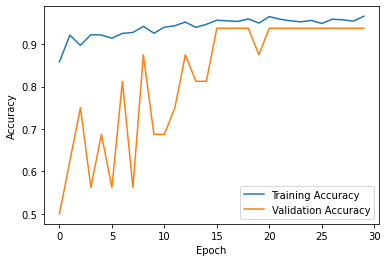

In [402]:
#plot graph
plt.plot(model_history.history['acc'],label='Training Accuracy')
plt.plot(model_history.history['val_acc'],label='Validation Accuracy')

plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

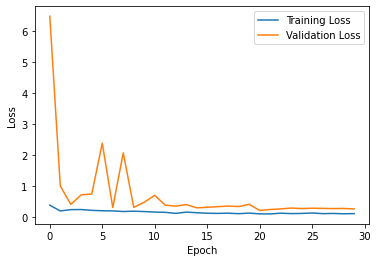

In [403]:
#plot graph
plt.plot(model_history.history['loss'],label='Training Loss')
plt.plot(model_history.history['val_loss'],label='Validation Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

<Figure size 576x432 with 0 Axes>

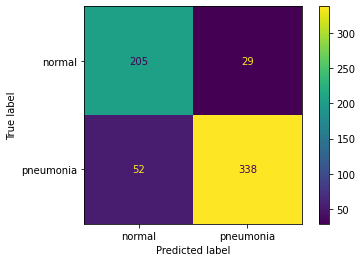

In [404]:
conf_mat=(confusion_matrix(y_test, model_y_pred))
plt.figure(figsize=(8,6))
display = metrics.ConfusionMatrixDisplay(confusion_matrix = conf_mat, display_labels=LB.classes_)
display.plot()
plt.show()